In [8]:
import tensorflow as tf
from tensorflow import keras
from tools import minMaxScale, wavelength2rgb
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import cv2

* [How connect spectrum](www.fourmilab.ch/documents/specrend/)
* [Python library](https://python-colormath.readthedocs.io/en/latest/color_objects.html#spectralcolor)


In [9]:
def prepare_data(image_path,
                 visible_channels=16,
                 predicted_channel=26):

    input_data = sio.loadmat(image_path)['data']

    visible = input_data[:, :, 0:visible_channels] / 255.0
    target = np.expand_dims(input_data[:, :,  predicted_channel] / 255.0, axis=-1)
    return visible, target

def get_cnn_dataset(visible,
                    target,
                    input_size=3,
                    ):
    assert (input_size - 1) % 2 == 0
    px_padding = (input_size - 1) // 2
    target = target[px_padding:visible.shape[0]-px_padding,
                    px_padding:visible.shape[1]-px_padding]

    l = []
    arr = visible
    for x in range(px_padding, visible.shape[0]-px_padding):
        for y in range(px_padding, visible.shape[1]-px_padding):
            l.append(arr[x-px_padding:x+px_padding+1, y-px_padding:y+px_padding+1])
    inputs = np.array(l)
    outputs = target.reshape([target.shape[0] * target.shape[1],
                              1,
                              1,
                              target.shape[2]])
    return inputs, outputs, target

In [10]:
image_path = '../data/raw/still_life/sample_22.mat'
visible, target = prepare_data(image_path)
inputs, outputs, pad_output = get_cnn_dataset(visible, target, input_size=5)

training_set_size = 2500
perm = np.random.permutation(inputs.shape[0])
ins = inputs[perm[:training_set_size], :]
outs = outputs[perm[:training_set_size], :]

target = target[1:target.shape[0]-1, 1:target.shape[1]-1]

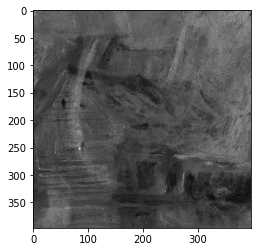

In [11]:
plt.imshow(pad_output, cmap=plt.cm.gray)

In [14]:
def str2layer(text):
    option_separator = '-'
    # Supported types
    #  * Convolution2D - C-[filters]-[kernel_size]-[activation]-[padding]
    #  * Dense - D-[units]-[activation]
    text = text.lower()
    options = text.split(option_separator)
    if text[0] == 'c':
        assert 3 <= len(options) <= 5, f"Every conv layer has 3-5 parameters, {text} has {len(options)}"
        kwargs = {'filters': int(options[1]),
                  'kernel_size': int(options[2]),
                  'activation': options[3] if len(options) > 3 else None,
                  'padding': options[4] if len(options) > 4 else 'valid'
                  }
        return keras.layers.Conv2D(**kwargs)
    elif text[0] == 'd':
        assert len(options) == 3, f"Every dense layer has 2-3 parameters, {text} has {len(options)}"
        kwargs = {
            'units' : int(options[1]),
            'activation': options[2] if len(options) > 1 else None,
        }
        return keras.layers.Dense(**kwargs)

def ig_cnn_model(def_text, input_channels=16, output_units=1, name='IG-CNN'):
    layer_separator = ','
    input_shape = [None, None, input_channels]
    layers = [keras.layers.Input(shape=input_shape)]

    layers_text = def_text.split(layer_separator)
    for layer_text in layers_text:
        layers.append(str2layer(layer_text))

    layers.append(keras.layers.Dense(units=output_units,
                                     activation='sigmoid'))

    return keras.Sequential(layers=layers, name=f'{name}:{def_text}')

In [15]:
model_def = "C-25-3-sigmoid-valid,C-25-1-sigmoid-same"
model = ig_cnn_model(model_def)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [39]:
model.summary()
model.name

Model: "IG-CNN;C-25-3-sigmoid-valid,C-25-1-sigmoid-same"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 25)    3625      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 25)    650       
_________________________________________________________________
dense (Dense)                (None, None, None, 1)     26        
Total params: 4,301
Trainable params: 4,301
Non-trainable params: 0
_________________________________________________________________


'IG-CNN;C-25-3-sigmoid-valid,C-25-1-sigmoid-same'

In [40]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error']
              )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=6, min_delta=10 ** -5),
             tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..', 'logs', model.name))
            ]
history = model.fit(ins,
                    outs,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks
                    )

Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 0s 160us/sample - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/100
2000/2000 [==============================] - 0s 87us/sample - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 3/100
2000/2000 [==============================] - 0s 81us/sample - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0033 - val_mean_squared_error

In [18]:
print(model.predict(inputs).shape)
print(outputs.shape)
# calculate gain and print it out
gain = abs(outputs - model.predict(inputs)) / (outputs.shape[0] * outputs.shape[1])
print('Gain: {:1.4e}'.format(gain.flatten().max()))

(157609, 3, 3, 1)
(157609, 1, 1, 1)
Gain: 3.9556e-06


In [71]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(pad_output.shape)

diff = (pad_output-approx) - np.min(pad_output-approx)
diff = diff/np.max(diff)

imgs = np.concatenate([pad_output, approx, diff], axis=1)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()


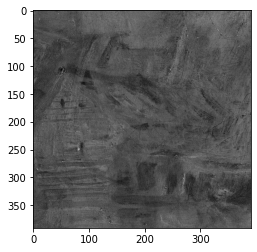

In [66]:
plt.imshow(diff, cmap=plt.cm.gray)

In [31]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is DE3B-991C

 Directory of C:\Users\Tomas Karella\Desktop\igre\notebooks

12/06/2020  03:20 PM    <DIR>          .
12/06/2020  03:20 PM    <DIR>          ..
11/21/2020  11:11 PM                 0 .gitkeep
11/21/2020  11:11 PM            23,178 01-igre-by-CNN-debug.ipynb
11/21/2020  11:11 PM         6,470,751 02-saul-decorrelation.ipynb
12/02/2020  03:32 PM           332,332 image.png
12/02/2020  03:30 PM           332,332 image2.png
12/02/2020  03:32 PM           334,602 image3.png
12/06/2020  12:29 PM    <DIR>          logs
12/02/2020  06:01 PM         2,469,659 still_life.png
12/06/2020  03:20 PM           379,393 tk-cnn.ipynb
12/02/2020  06:30 PM           246,380 tk-test.ipynb
12/02/2020  03:47 PM             2,947 tools.py
12/02/2020  05:52 PM    <DIR>          __pycache__
              10 File(s)     10,591,574 bytes
               4 Dir(s)  103,788,376,064 bytes free


'..\\logs'

In [35]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(target.shape)

diff = minMaxScale(target - approx)

imgs = np.concatenate(
    [ np.concatenate([target, approx], axis=1),
    np.concatenate([diff, diff], axis=1)],
    axis=0)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [22]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is DE3B-991C

 Directory of C:\Users\Tomas Karella\Desktop\igre\notebooks

12/06/2020  12:30 PM    <DIR>          .
12/06/2020  12:30 PM    <DIR>          ..
11/21/2020  11:11 PM                 0 .gitkeep
11/21/2020  11:11 PM            23,178 01-igre-by-CNN-debug.ipynb
11/21/2020  11:11 PM         6,470,751 02-saul-decorrelation.ipynb
12/02/2020  03:32 PM           332,332 image.png
12/02/2020  03:30 PM           332,332 image2.png
12/02/2020  03:32 PM           334,602 image3.png
12/06/2020  12:29 PM    <DIR>          logs
12/02/2020  06:01 PM         2,469,659 still_life.png
12/06/2020  12:30 PM           376,759 tk-cnn.ipynb
12/02/2020  06:30 PM           246,380 tk-test.ipynb
12/02/2020  03:47 PM             2,947 tools.py
12/02/2020  05:52 PM    <DIR>          __pycache__
              10 File(s)     10,588,940 bytes
               4 Dir(s)  103,799,005,184 bytes free


In [244]:
image_path = '../data/raw/still_life/allChannels.mat'
image = sio.loadmat(image_path)['sl']

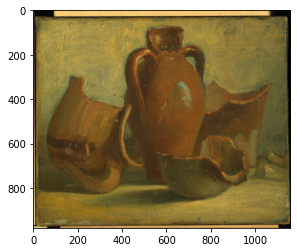

In [253]:
plt.imshow(wavelength2rgb(image[:, :, :16] / 255.0))
plt.imsave('still_life.png',wavelength2rgb(image[:, :, :16] / 255.0))

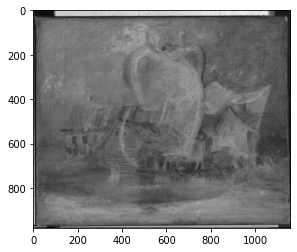

In [257]:
plt.imshow(image[:,:,26], cmap='gray')

In [266]:
plt.imsave('../data/raw/still_life/sample_22_CNN.png',np.squeeze(diff), cmap='gray')